In [11]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.masking import apply_mask,unmask
import pandas as pd
import os
from isc_tools import *

In [2]:
froot = '/data00/layerfMRI/'
datafld = froot + 'Github_repo/layerfMRI/analyses/dual_ISC/TC_4_lorenzo/'
os.listdir(datafld)

['M_OR_S_JU_time_courses_thr100_bin9.csv',
 'M_OR_S_JU_time_courses_thr100_bin4.csv',
 'M_OR_S_JU_time_courses_thr100_bin3.csv',
 'M_OR_S_JU_time_courses_thr100_bin10.csv',
 'M_OR_S_JU_time_courses_thr100_bin7.csv',
 'RESULTS',
 'M_OR_S_JU_time_courses_thr100_bin5.csv',
 'M_OR_S_JU_time_courses_thr100_bin6.csv',
 'M_OR_S_JU_time_courses_thr100_bin8.csv']

In [3]:
logsumm = (pd
           .read_csv(froot+ 'logs/log_summary.csv')
           .assign(fmri = lambda d:
                   froot + 
                   'regdata/sub_' + d['subject'].apply(lambda n: '{:02d}'.format(n)) +
                   '/ses_' + d['session'].apply(lambda n: '{:02d}'.format(n)) +
                   '/func/task_' + d['task'].apply(lambda n: '{:01d}'.format(n)) +
                   '_run_' + d['run'].apply(lambda n: '{:01d}'.format(n)) +
                   '_4D_MNI.nii.gz'
                  )
           .assign(fmri_missing = lambda d : d['fmri'].apply(lambda s: os.path.isfile(s) != True))
           
          )


movie_length = {}

for mv in logsumm.Title.unique():
    durations = logsumm.loc[lambda d : d['Title'] == mv].ExpectedDuration.unique()
    if len(durations) != 1:
        print('Warning! More than one duration found')
        movie_length[mv] = np.min(durations)
    else:
        movie_length[mv] = durations[0]



In [5]:
nbins = 3
thr = 100
method = 'M_OR_S'

In [6]:
f = f'{method}_JU_time_courses_thr{thr}_bin{nbins}.csv'

# Read dataframe
df = pd.read_csv(datafld + f)

# Transform timecourses into numpy arrays and standardize them
df['tc_mean_unfolded'] = (df['tc_mean_unfolded']
                          .map(r2numpy)
                         )

# Correct for movies that are missing the last frame
df['measured_movl'] = df.apply(lambda row : len(row['tc_mean_unfolded']), axis = 1)
df['expected_movl'] = df.apply(lambda row : movie_length[row['muvi']], axis = 1)

corrected_movl = (df
                  .loc[lambda d : d['expected_movl'] > d['measured_movl']]
                  .groupby('muvi')
                  .apply(lambda d: np.min(d['measured_movl']))
                 )

for m in dict(corrected_movl):
    movie_length[m] = corrected_movl[m]
#####################################################

df['tc_mean_trimmed'] = (df
                         .apply(lambda row : row['tc_mean_unfolded'][:movie_length[row['muvi']]], axis = 1)
                         .map(stdize)
                        )

df['measured_movl'] = df.apply(lambda row : len(row['tc_mean_trimmed']), axis = 1)

# Get movie names
movie_names = {}
for c,gdf in df.groupby(['contrast']):
    movie_names[c] = gdf.sort_values(['muvi']).muvi.unique()

# Concatenate movie and task
cdf  = pd.DataFrame()
count = 0

for [c,s,j,d],gdf in df.groupby(['contrast','sub','JU','D_bins']):

    gdf = gdf.sort_values(['muvi','run'])
    movie_list = gdf['muvi'].unique()

    try:
        same = (movie_names[c] == movie_list).all()
    except:
        same = False
    if not same:
        print(f'Error! contrast {c} subject {s} JU {j} D_bins {d}')
    else:
        count += 1

    concatenated = np.hstack(gdf['tc_mean_trimmed'])

    temp_df = gdf.iloc[0][['contrast','sub','JU','D_bins']]
    temp_df['tc_concatenated'] = concatenated

    cdf = cdf.append(temp_df)

In [7]:
sel_JUs = {'BA44':13, 'PFt':35, 'BA6':91, 'Vis':200}
JU_names = {sel_JUs[ju]:ju for ju in sel_JUs}
# sel_JUs.values()

In [15]:
def extract_decay(dataf):

    R = np.zeros((nbins,nbins))
    decay = np.zeros(nbins)

    for l1,layer1_timecourse in enumerate(dataf['tc_concatenated'].values):
        for l2,layer2_timecourse in enumerate(dataf['tc_concatenated'].values[l1:]):
            R[l1,l2+l1] = np.corrcoef(layer1_timecourse,layer2_timecourse)[1,0]

    decay = [np.average(np.diag(R,i)) for i in range(nbins)]
    
    return decay

In [16]:
decays = {j : [] for j in sel_JUs.values()}

for (c,j,s),df in cdf.groupby(['contrast','JU','sub']):
    try:
        decays[j].append(extract_decay(df))
    except:
        pass

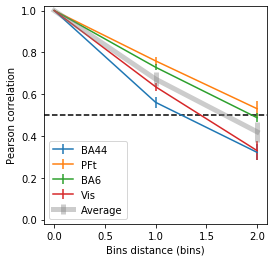

In [18]:
plt.figure(figsize = (4,4))

for j in decays:
    A = np.array(decays[j])
    plt.errorbar(np.arange(nbins),
                 np.average(A,axis=0),
                 yerr=np.std(A,axis=0)/np.shape(A)[1],
                 label = JU_names[j])
    
A = np.concatenate([decays[j] for j in decays])
plt.errorbar(np.arange(nbins),
             np.average(A,axis=0),
             yerr=np.std(A,axis=0)/np.shape(A)[1],
             label = 'Average', color = 'gray',
             linewidth = 5, alpha = 0.4)



plt.axhline(0.5,0,1,color = 'k', linestyle = '--')
plt.ylim([-0.02,1.02])
plt.xlim([-0.1,nbins-1+0.1])
plt.xlabel('Bins distance (bins)')
plt.ylabel('Pearson correlation')
plt.legend()

In [159]:
extract_decay(test_df)

[1.0,
 0.6520296590263813,
 0.5526699489900684,
 0.48569313370420736,
 0.4377787713430972,
 0.3991057652455646,
 0.38589068896580697,
 0.3214562168389643,
 0.20700953678167155,
 0.18788548060534285]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(R, vmin =0, vmax = 1, cmap='viridis')

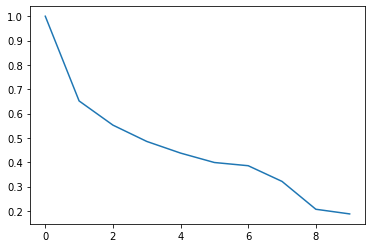

In [53]:
plt.plot(decay)